In [101]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook


In [92]:
class A:
    
    def __init__(self, u):
        self.u = u
        self.ag = None
        self.unique_resnames = None
        
    def select_atoms(self, sel):
        """
        Method for selecting the atoms using MDAnalysis selections

        Args:
            sel (str): selection string

        """
        self.ag = self.u.select_atoms(sel)
        self.unique_resnames = np.unique(self.ag.resnames)

    @staticmethod
    def make_grid(pbc_dim: int, dim=1, d4=None) -> np.ndarray:
        """
        Returns a 4D matrix

        Args:
             pbc_dim (int): Dimensions of the box
             dim (int): Dimensions of the box
             d4 (int): Returns an 4-D matrix if d4 is given. 4th dimension contains d4 elements
        """

        x = y = z = int(pbc_dim // dim) + 1
        print(x, y, z)
        grid_matrix = np.zeros((x, y, z)) if d4 is None else np.zeros((x, y, z, d4))

        return grid_matrix
    
    @staticmethod
    def check_cube(x: float, y: float, z: float, rescale=1) -> tuple:
        """
        Find to which cube does the atom belong to
        Args:
            x (float): x coordinate
            y (float): y coordinate
            z (float): z coordinate
            rescale (int): rescale factor

        Returns:
            tuple: Coordinates of the node inside the grid where the point belongs
        """

        # n_x = round(x / rescale_coef)
        # n_y = round(y / rescale_coef)
        # n_z = round(z / rescale_coef)
        n_x = int(x / rescale)
        n_y = int(y / rescale)
        n_z = int(z / rescale)

        return n_x, n_y, n_z
    def _calc_mesh(self, grid_dim, rescale, ag, diff=False):
        """
        Calculates the mesh according the atom positions in the box

        Args:
            grid_dim (int): Box dimensions
            rescale: rescale factor
            diff: Is True if we are calculating a mesh for other than the main structure

        Returns:
            np.ndarray: The grid
        """
        grid_matrix = self.make_grid(pbc_dim=grid_dim, dim=rescale, d4=len(self.unique_resnames))

        if ag is None:
            ag = self.ag

        for atom in ag:
            x, y, z = self.check_cube(*atom.position, rescale=rescale)
            res_number = 0 if not diff else np.where(self.unique_resnames == atom.resname)
            grid_matrix[x, y, z, res_number] += 1

        return grid_matrix
    
    def _get_int_dim(self):
        return self.u.dimensions[0]
    
    def calculate_mesh(self, selection=None, main_structure=False, rescale=1):
        """
        Calculates the mesh using _calc_mesh private method
        Args:
            selection: Selection for atom group to calculate mesh
            rescale: rescale factor
            main_structure (bool): use as the main structure if true (e.g. densities are calculated relative to this)
        Returns:
            np.ndarray: Returns the grid matrix
        """
        # find closest atoms and rescale positions according to this
        grid_dim = self._get_int_dim()  # get one dimension
        atom_group = self.u.select_atoms(selection) if selection is not None else self.ag

        # define the matrices
        grid_matrix = self._calc_mesh(grid_dim, rescale, atom_group, main_structure)

        if main_structure:  # if selection is None, then it's the main structure
            self.grid_matrix = grid_matrix

        return grid_matrix

In [93]:
u = mda.Universe('InP_sphere_r_29.pdb')

C:\Users\hrach\AppData\Local\Programs\Python\Python310\lib\site-packages\MDAnalysis\topology\guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: IN
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [94]:
a = A(u)

In [110]:
a.select_atoms('name IN')

In [111]:
a.calculate_mesh(main_structure=True)

60 60 60


array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [112]:
def make_coordinates(mesh, keep_numbers=False):
    """
    Converts the mesh to coordinates
    Args:
        mesh (np.ndarray):  Mesh to convert into 3D coordinates
        keep_numbers (bool): Resulting tuples will also contain the number of particles at that coordinate if True

    Returns:
        np.ndarray: Ndarray of tuples representing coordinates of each of the points in the mesh
    """

    coords = []
    for i, mat in enumerate(mesh):
        for j, col in enumerate(mat):
            for k, elem in enumerate(col):
                if elem > 0:
                    coords.append((i, j, k)) if not keep_numbers else coords.append((i, j, k, mesh[i, j, k]))

    return np.array(coords, dtype=int)

In [113]:
coords = make_coordinates(a.calculate_mesh(main_structure=True))

60 60 60


<IPython.core.display.Javascript object>


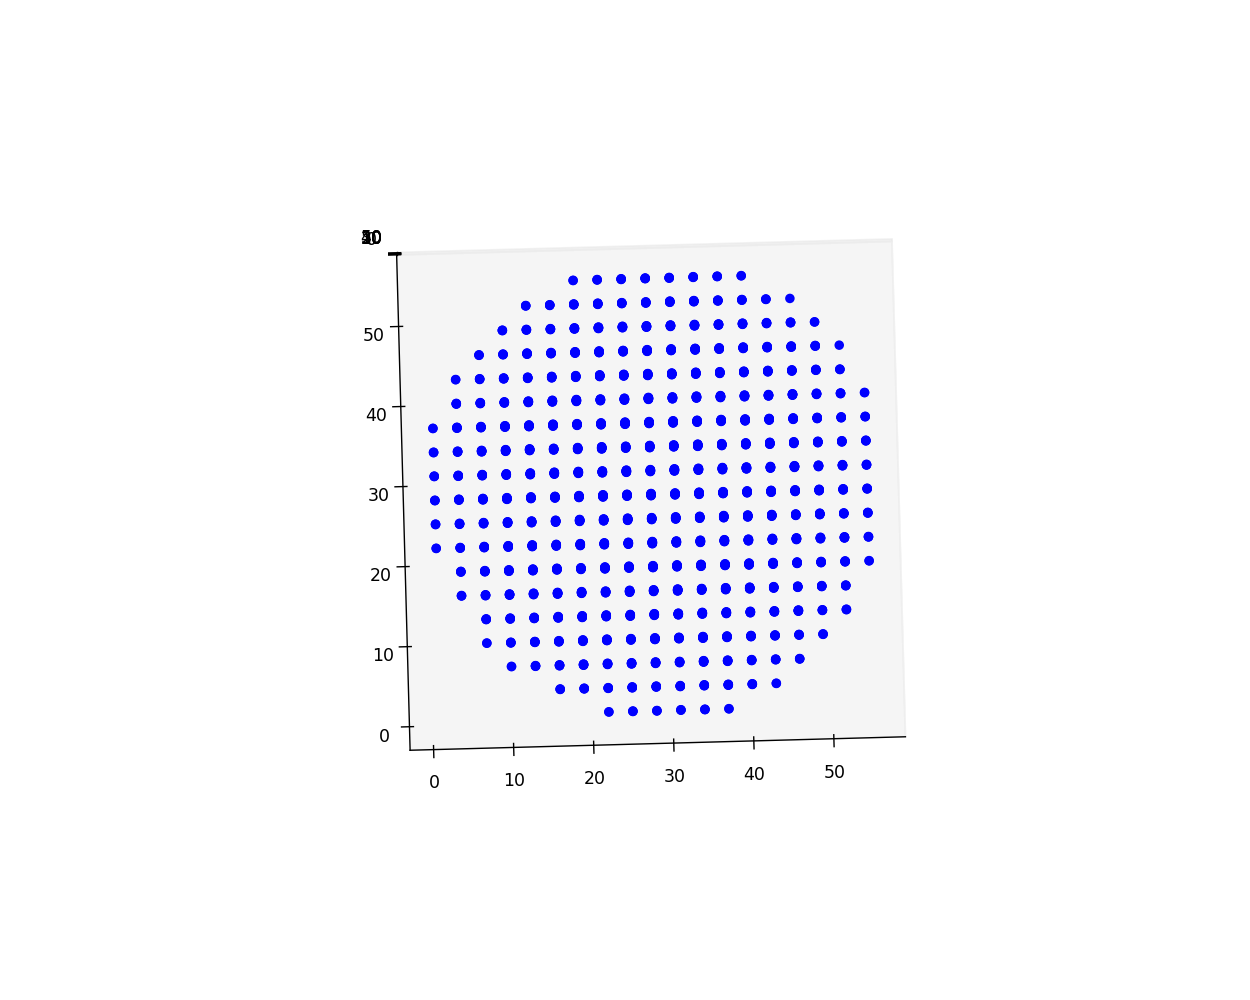

In [115]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d', proj_type='ortho')

ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], color='blue', alpha=1)
ax.grid(False)
# plt.axes(None)
plt.show()